In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, rc
from astropy import cosmology, units, constants

from ska_simulator.power_spectrum import power_spectrum
from ska_simulator.simulations import thermal_noise

%load_ext autoreload
%autoreload 2

## Parameters

In [3]:
# 21cm rest-frame frequency
nu0 = 1420 * units.MHz

In [4]:
# Simulation angular specs
ang_res = 16.*units.arcsec # angular resolution
#number of pixels in row and col (ang res)
npix = 2048
#length and width of the box in Mpc
fov = ang_res.to(units.rad) * npix #rad

In [6]:
fov.to(units.deg)

<Quantity 9.10222222 deg>

In [4]:
# Simulation spectral specs
nfreqs = 151
fmin = 166. * units.MHz
fmax = 181. * units.MHz
spw_window = np.linspace(fmin.value, fmax.value, nfreqs, endpoint=True) * units.MHz
df = np.median(np.diff(spw_window)).to(units.Hz)

avg_nu = np.mean(spw_window)
avg_z = np.mean(nu0/spw_window - 1.)
avg_lamb = constants.c.si / avg_nu.si

print(f'{spw_window.size} frequency channels, '
      f'mean frequency {avg_nu.to(units.MHz):.1f}, '
      f'mean redshift {avg_z:.1f}.')

151 frequency channels, mean frequency 173.5 MHz, mean redshift 7.2.


In [7]:
# telescope parameters
nb_antennas = 512
tint = 1000. * units.hour
# collecting area
D_station = (35. + 40.)/2 * units.m  # station diameter
A_collect = np.pi * D_station**2 / 4.  # station area
# Beam FWHM
bmaj = 0.04413
bmin = 0.03291
beam_fwhm = np.array([bmaj, bmin]) * units.deg
beam_sigma = beam_fwhm / (8 * np.log(2))**0.5
omega_B = 2 * np.pi * beam_sigma[0] * beam_sigma[1]
print(f'Beam area = {omega_B:.2e}')


Beam area = 1.65e-03 deg2


## Generate noise random field

In [10]:
noise_model = thermal_noise(
    npix=npix,
    freqs=spw_window,
    nb_antennas=nb_antennas,
    collecting_area=A_collect,
    Tsys=None,
    integration_time=tint,
    beam_area=omega_B,
    output_unit=units.K,
)
noise_cube = noise_model.make_noise_box()
print(f'Standard deviation of the noise simulation: {noise_model.std[nfreqs//2].to(units.mK):.2e}'
      f' or {noise_model.std.to(units.Jy/units.beam, equivalencies=noise_model.Jy_to_K)[nfreqs//2]:.2e}'
      f' at {spw_window[nfreqs//2]}')


Standard deviation of the noise simulation: 3.48e+00 mK or 1.61e-06 Jy / beam at 173.5 MHz


In [15]:
noise_model = thermal_noise(
    npix=npix,
    freqs=spw_window,
    nb_antennas=nb_antennas,
    collecting_area=A_collect,
    Tsys=None,
    integration_time=tint,
    beam_area=omega_B,
    output_unit=units.K,
)
# noise_cube = noise_model.make_noise_box()
print(f'Standard deviation of the noise simulation: {noise_model.std[nfreqs//2].to(units.mK):.2e}'
      f' or {noise_model.std.to(units.Jy/units.beam, equivalencies=noise_model.Jy_to_K)[nfreqs//2]:.2e}'
      f' at {spw_window[nfreqs//2]:.1f}')


Standard deviation of the noise simulation: 6.94e+06 mK or 3.22e+00 Jy / beam at 173.5 MHz


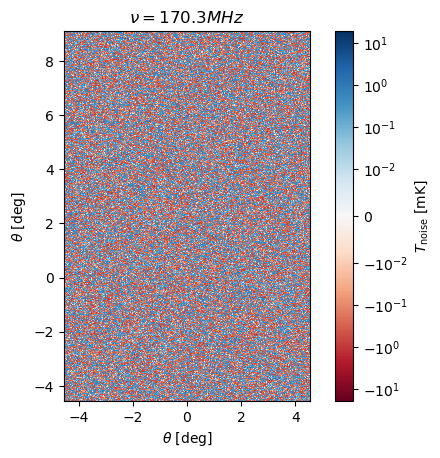

In [7]:
#Let's see a random freq slice 
fig, ax = plt.subplots()
im = ax.imshow(noise_cube[:, :, 43].to(units.mK).value,
           origin='lower',
           extent=(-fov.to(units.deg).value/2, fov.to(units.deg).value/2, -fov.to(units.deg).value/2, fov.to(units.deg).value),
           cmap='RdBu',
           norm=colors.SymLogNorm(1e-2)
           )
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\theta$ [deg]')
ax.set_title(rf'$\nu = {spw_window[43].to(units.MHz):.1f}$')
plt.colorbar(im, label=r'$T_\mathrm{noise}$ [mK]')

### Compute power spectrum numerically from the simulation

In [8]:
cos = cosmology.Planck18

In [9]:
# k-range
datafolder = '../test_dataset/'
kperp_bins = np.loadtxt(f'{datafolder}bins_kper.txt')
kpara_bins = np.loadtxt(f'{datafolder}bins_kpar.txt')
k_mag = np.sqrt(kpara_bins[:, None]**2 + kperp_bins[None, :]**2)

kmin = np.min(k_mag) / units.Mpc
kmax = np.max(k_mag) / units.Mpc
krange = np.linspace(kmin, kmax, 10).value

In [10]:
# power spectrum of noise only
pspec_noise = power_spectrum(
    data=noise_cube.to(units.mK),
    theta_x=fov,
    theta_y=fov,
    freqs=spw_window,
    rest_freq=nu0,
    space_taper=None,
    freq_taper=None,
    cosmo=cos,
    convert_data_to=None,
    verbose=False
)
# Get FT fields
ps_box_noise = pspec_noise.FFT_crossxx(deconvolve=False)

#### Spherical power spectrum

In [11]:
# spherical PS
_, pspec_1d_noise = pspec_noise.compute_1D_pspec(
    ps_data=ps_box_noise,
    kbins=krange
)

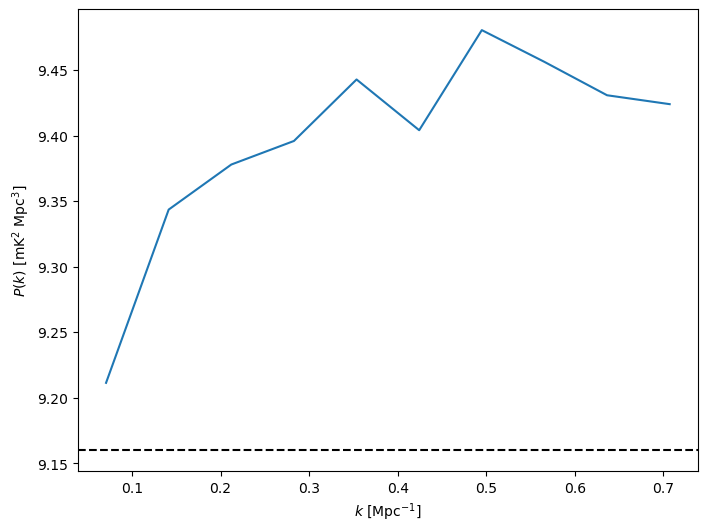

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(krange, pspec_1d_noise, label = 'Noise power spectrum')
ax.set_ylabel(rf"$P(k)$ [{pspec_noise.data_unit.to_string()}$^2$ Mpc$^3$]")
ax.set_xlabel(r"$k$ [Mpc$^{-1}$]")

est_amplitude = pspec_noise.volume_element * units.Mpc**3 \
    * noise_model.std[noise_model.nfreqs//2].to(pspec_noise.data_unit)**2
ax.axhline(est_amplitude.value, ls='--', color='k')

#### Cylindrical power spectrum

In [13]:
# cylindrical PS
_, _, pspec_2d_noise = pspec_noise.compute_2D_pspec(
    ps_data=ps_box_noise,
    k_perp_bin=kperp_bins,
    k_par_bin=kpara_bins
)

Text(0.5, 0, 'k$_\\perp$ [Mpc$^{-1}]$')

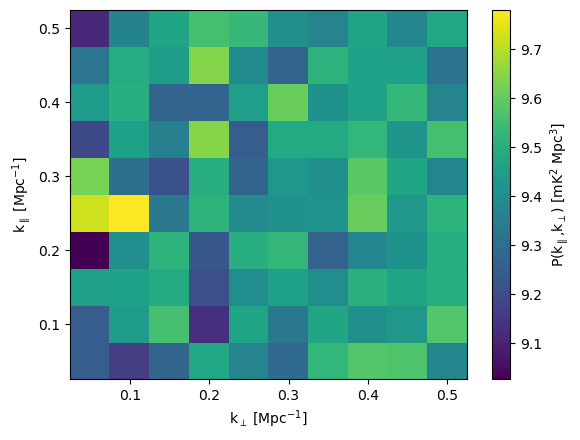

In [14]:
im = plt.pcolor(kperp_bins,
                kpara_bins,
                pspec_2d_noise,
                shading='auto')
plt.colorbar(label = f'P(k$_\parallel$,k$_\perp$) [{pspec_noise.data_unit}$^2$ Mpc$^3$]')
plt.ylabel('k$_\parallel$ [Mpc$^{-1}]$')
plt.xlabel('k$_\perp$ [Mpc$^{-1}]$')